# 🗣️  💻 VOICE RECOGNITION EVALUATION NOTEBOOK


## 🛠️ Install packages

In [ ]:
! pip install nemo_toolkit['asr']
! pip install datasets

## 📥 Import modules

In [2]:
#Nemo
import nemo.collections.asr as nemo_asr
#Huggingface datasets
from datasets import load_dataset, Audio
#Other useful modules
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

## 🔑 Log into Huggingface to use the CommonVoice dataset
Make sure to generate a token first here: https://huggingface.co/settings/tokens


In [ ]:
! huggingface-cli login

## 🔃 Load the dataset and preprocess it

### Select the language to evaluate
**Languages available**: <br>
Abkhaz, Arabic, Armenian, Assamese, Asturian, Azerbaijani, Basaa, Bashkir, Basque, Belarusian, Bengali, Breton, Bulgarian, Cantonese, Catalan, Central Kurdish, Chinese (China), Chinese (Hong Kong), Chinese (Taiwan), Chuvash, Czech, Danish, Dhivehi, Dioula, Dutch, English, Erzya, Esperanto, Estonian, Finnish, French, Frisian, Galician, Georgian, German, Greek, Guarani, Hakha Chin, Hausa, Hill Mari, Hindi, Hungarian, Icelandic, Igbo, Indonesian, Interlingua, Irish, Italian, Japanese, Kabyle, Kazakh, Kinyarwanda, Korean, Kurmanji Kurdish, Kyrgyz, Lao, Latvian, Lithuanian, Luganda, Macedonian, Malayalam, Maltese, Marathi, Meadow Mari, Moksha, Mongolian, Nepali, Norwegian Nynorsk, Occitan, Odia, Persian, Polish, Portuguese, Punjabi, Quechua Chanka, Romanian, Romansh Sursilvan, Romansh Vallader, Russian, Sakha, Santali (Ol Chiki), Saraiki, Sardinian, Serbian, Slovak, Slovenian, Sorbian, Upper, Spanish, Swahili, Swedish, Taiwanese (Minnan), Tamil, Tatar, Thai, Tigre, Tigrinya, Toki Pona, Turkish, Turkmen, Twi, Ukrainian, Urdu, Uyghur, Uzbek, Vietnamese, Votic, Welsh, Yoruba

**Language codes:**<br>
All codes can be found here: https://huggingface.co/datasets/mozilla-foundation/common_voice_13_0

In [4]:
input_lang = 'hi'

### Load the dataset and prepare it.
We download a the test set of the common voice dataset. We resample to 16kHz as this is the expected input for the TitaNet model and we take out recordings that are either too short (less than 3 seconds) or too long (more than 30 seconds).

#### Download and select only 2000 recordings

In [6]:
cv_13 = load_dataset("mozilla-foundation/common_voice_13_0", input_lang, split=["test"], trust_remote_code=True)
cv_13_filtered = cv_13[0].select(range(2000))

#### Display number of recordings in the dataset

In [8]:
print(f"Number of recordings: {len(cv_13[0])}")
print(f"Number of recordings in filtered dataset: {len(cv_13_filtered)}")

Number of recordings: 2947
Number of recordings in filtered dataset: 2000


#### Add a column in the dataset for the length of the audio file

In [9]:
def prepare_dataset(example):
    info = sf.info(example['path'])
    duration = info.duration
    example['duration']=duration
    return example

cv_13_filtered = cv_13_filtered.map(
    prepare_dataset, num_proc=4, batch_size=100
)

[NeMo W 2024-05-10 19:12:37 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    


Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

#### Apply filtering to the dataset

In [10]:
min_input_length=3
max_input_length=30

def is_audio_in_length_range(length):
    return max_input_length > length > min_input_length

cv_13_filtered = cv_13_filtered.filter(
    is_audio_in_length_range,
    input_columns=["duration"],
)

print(f"Number of recordings: {len(cv_13_filtered)}")

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Number of recordings: 1844


## 🧮 Load the model and compute embeddings for all recordings
For each file, we extract the embedding of the voice and store it in a dictionary. As we have the speaker ID and a same speaker can have multiple recordings, we want to have multiple embeddings for the same user.<br>

Embeddings:
`{ 'id' : [array of speaker ID], 'vect': [array of embeddings] }`

Also, each recording is resampled to 16kHz and saved as a wav file since this is expected by the model

In [11]:
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

embeddings={'id':[], 'vect' : []}

#Resample to 16kHz and generate a wav file instead of a mp3
def resample(path):
  data, sr = librosa.load(path, sr=None)
  resampled_data = librosa.resample(data, orig_sr=sr, target_sr=16000)
  new_path = path.replace('.mp3', '.wav')
  sf.write(new_path, resampled_data, 16000)
  return new_path

for rec in tqdm(cv_13_filtered):
  path = resample(rec['path'])
  embs = speaker_model.get_embedding(path)
  embeddings['id'].append(rec['client_id'])
  embeddings['vect'].append(embs)

[NeMo I 2024-05-10 19:14:02 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/titanet_large/versions/v1/files/titanet-l.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2024-05-10 19:14:05 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-10 19:14:05 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2024-05-10 19:14:05 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2024-05-10 19:14:05 features:289] PADDING: 16
[NeMo I 2024-05-10 19:14:07 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


100%|██████████| 1844/1844 [01:32<00:00, 19.98it/s]


### Define useful function to compute cosine similarity between 2 embeddings

In [12]:
def cosine(t1,t2):

  norm1 = t1 / torch.norm(t1)
  norm2 = t2 / torch.norm(t2)

  # Compute the dot product
  dot_product = torch.dot(norm1, norm2)

  # Calculate the cosine similarity
  cosine_similarity = dot_product / (torch.norm(norm1) * torch.norm(norm2))

  #Set the value between 0 and 1
  score = 0.5 * (1 + cosine_similarity.item())
  return score

###  For each embedding, compute its cosine similarity with all others
If same user, store the information in positives. Else, store it in negatives.

In [13]:
positives=[]
negatives=[]
n_max=len(cv_13_filtered)
for ind1, vect1 in tqdm(enumerate(embeddings['vect'][0:n_max])):
  for ind2, vect2 in enumerate(embeddings['vect'][0:ind1]):
    score = cosine(vect2[0], vect1[0])
    if embeddings['id'][ind1]==embeddings['id'][ind2]:
      positives.append(score)
    else:
      negatives.append(score)

1844it [05:27,  5.63it/s]


In [14]:
print(f"Positives: {len(positives)}")
print(f"Negatives: {len(negatives)}")

Positives: 15546
Negatives: 1683700


## 📊 Display outcome in a graph

### Distribution of scores for negatives and positives

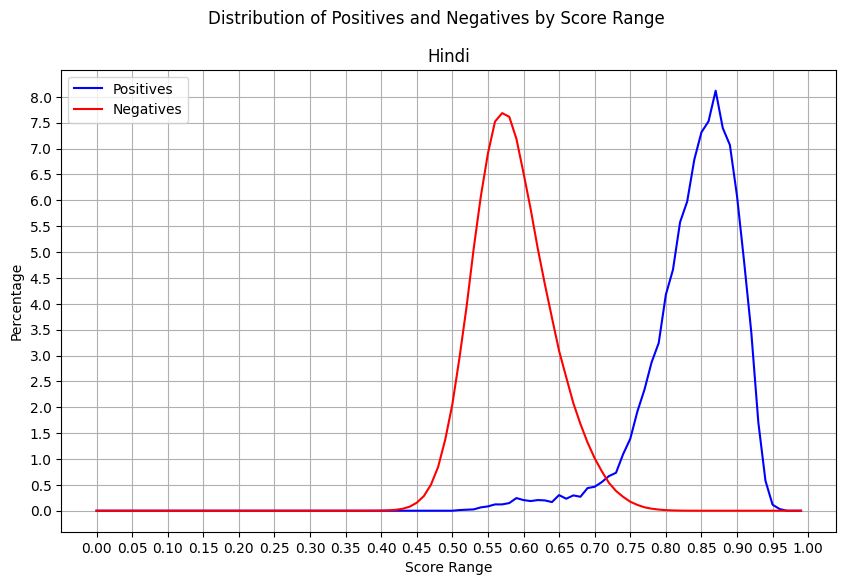

In [15]:
# Define the intervals
intervals = np.arange(0, 1.01, 0.01)

# Calculate the total number of items
total_positives = len(positives)
total_negatives = len(negatives)

# Count the number of positives and negatives in each interval
positive_counts, _ = np.histogram(positives, bins=intervals)
negative_counts, _ = np.histogram(negatives, bins=intervals)

# Calculate the percentage of positives and negatives in each interval
positive_percentages = (positive_counts / total_positives) * 100
negative_percentages = (negative_counts / total_negatives) * 100

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(intervals[:-1], positive_percentages, label='Positives', color='blue')
plt.plot(intervals[:-1], negative_percentages, label='Negatives', color='red')
plt.xlabel('Score Range')
plt.ylabel('Percentage')
plt.suptitle('Distribution of Positives and Negatives by Score Range')
plt.title('Hindi')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 1.01, 0.05))
# Dynamically adjust the vertical ticks based on the maximum value
max_percentage = max(np.max(positive_percentages), np.max(negative_percentages))
plt.yticks(np.arange(0, max_percentage, 0.5))
plt.savefig('positives_negatives_distribution.png')
plt.show()

### Metrics VS threshold

Intersection of Recall and Precision: [0.96969697 0.97979798 0.98989899 1.        ]
Intersection of Accuracy and Precision: [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.81818182 0.82828283 0.83838384 0.84848485 0.85858586 0.86868687
 0.87878788 0.88888889 0.8989899  0.90909091 0.91919192 0.92929293
 0.93939394 0.94949495 0.95959596]
Intersection of Accuracy and Recall: [0.6969697]
Intersection of Accuracy and F1-score: [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07

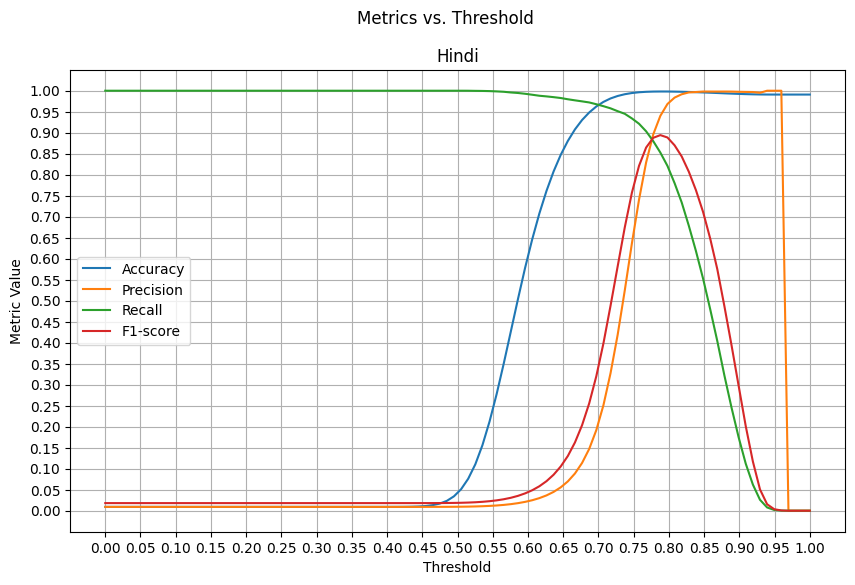

In [16]:
# Define a range of thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Compute metrics for each threshold
data_source_1 = np.array(positives)
data_source_2 = np.array(negatives)

for threshold in thresholds:
    fn = np.sum(data_source_1 < threshold)
    tp = np.sum(data_source_1 >= threshold)
    tn = np.sum(data_source_2 < threshold)
    fp = np.sum(data_source_2 >= threshold)

    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

# Find the threshold where accuracy and precision intersect
intersection_accuracy_precision = np.intersect1d(thresholds, thresholds[np.isclose(accuracy_list, precision_list, atol=0.01)])

# Find the threshold where accuracy and recall intersect
intersection_accuracy_recall = np.intersect1d(thresholds, thresholds[np.isclose(accuracy_list, recall_list, atol=0.01)])

# Find the threshold where accuracy and F1-score intersect
intersection_accuracy_f1 = np.intersect1d(thresholds, thresholds[np.isclose(accuracy_list, f1_list, atol=0.01)])

# Find the threshold where recall and precision intersect
intersection_recall_precision = np.intersect1d(thresholds, thresholds[np.isclose(recall_list, precision_list, atol=0.01)])

# Print the intersection point
print("Intersection of Recall and Precision:", intersection_recall_precision)
print("Intersection of Accuracy and Precision:", intersection_accuracy_precision)
print("Intersection of Accuracy and Recall:", intersection_accuracy_recall)
print("Intersection of Accuracy and F1-score:", intersection_accuracy_f1)

# Plot metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.suptitle('Metrics vs. Threshold')
plt.title('Hindi')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 1.01, 0.05))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()
